# Images Preprocessing


## imports



In [30]:
from commonfunctions import *
import numpy as np
import skimage.io as io

from skimage import  transform, exposure, segmentation, util
from sklearn import svm
import random
import cv2
# import matplotlib.pyplot as plt
# from skimage.color import rgb2gray
# from skimage.morphology import binary_erosion, binary_dilation, binary_closing,skeletonize, thin
# from skimage.measure import find_contours
# from skimage.draw import rectangle
# from PIL import Image

#ML 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from skimage import feature, color, morphology
# from scipy import ndimage as ndi
import os


## reading and gray scale conversion

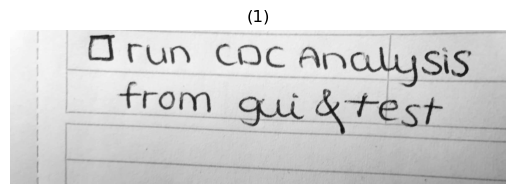

In [31]:
def readingAndConvert(img_path: str) -> np.ndarray:
    image = io.imread(img_path).astype(np.uint8)
    if len(image.shape) == 2:   
        return image
    else:
        gray_img = rgb2gray(image)
        return gray_img

# forged_imgs = os.listdir('dataset/forged')
# forged_img_imgs=[]
# for i in range(len(forged_imgs)):
#     forged_img_imgs.append(readingAndConvert('dataset/forged/'+forged_imgs[i]))


# real_imgs = os.listdir('dataset/real')
# real_img_imgs=[]
# for i in range(len(real_imgs)):
#     real_img_imgs.append(readingAndConvert('dataset/real/'+real_imgs[i]))

forged_imgs = os.listdir('1/forged/')
forged_img_imgs=[]
for i in range(len(forged_imgs)):
    forged_img_imgs.append(readingAndConvert('1/forged/'+forged_imgs[i]))

real_imgs = os.listdir('1/real/')
real_img_imgs=[]
for i in range(len(real_imgs)):
    real_img_imgs.append(readingAndConvert('1/real/'+real_imgs[i]))

test_image = readingAndConvert('./test.jpeg')

show_images([test_image])

## image resizing 

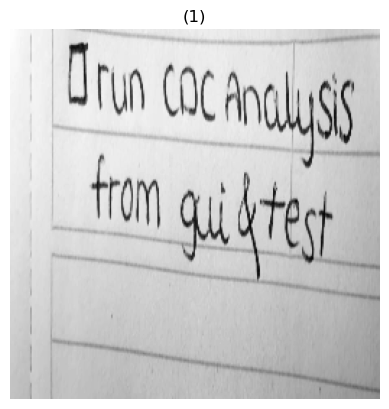

In [32]:
def resize_image(image: np.ndarray, target_size:tuple =(256, 256)) -> np.ndarray:
    resized_image = cv2.resize(image, target_size)
    return resized_image


resized_forged=[]
for i in range(len(forged_img_imgs)):
    resized_forged.append(resize_image(forged_img_imgs[i]))
    

resized_real=[]
for i in range(len(real_img_imgs)):
    resized_real.append(resize_image(real_img_imgs[i]))
# show_images(resized_real)

test_image = resize_image(test_image)

show_images([test_image])

## gamma correction 

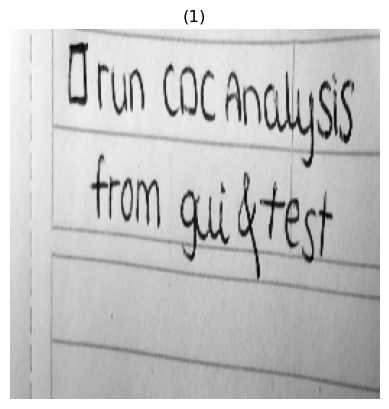

In [33]:
# Set the gamma value (e.g., 0.5 for darkening, 2.0 for brightening)
gamma_value = 1.5

gamma_corrected_forged=[]
for i in range(len(resized_forged)):
    gamma_corrected_forged.append(exposure.adjust_gamma(resized_forged[i], gamma=gamma_value))
 
gamma_corrected_real=[]
for i in range(len(resized_real)):
    gamma_corrected_real.append(exposure.adjust_gamma(resized_real[i], gamma=gamma_value))

test_image = exposure.adjust_gamma(test_image, gamma=gamma_value)
show_images([test_image])


## thresholding

## segmentation

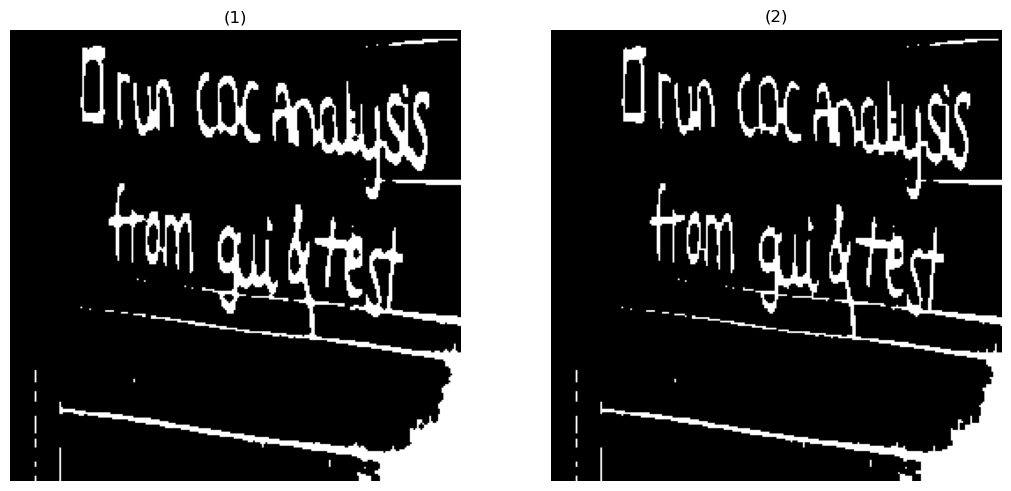

In [57]:
def region_filling(img: np.ndarray) -> np.ndarray:
    # Create a structuring element (kernel)
    selem = morphology.square(3)  # Creating a 3x3 square structuring element
    
    # Perform dilation using skimage's binary dilation
    dilated_img = morphology.dilation(img, selem)
    
    # Perform a bitwise and operation with itself (equivalent to keeping the image unchanged)
    result_img = np.bitwise_and(dilated_img, dilated_img)
    result_img = morphology.erosion(result_img)
    
    return result_img

def segmentation(image: np.ndarray, threshold: int) -> np.ndarray:
    _, binary_image = cv2.threshold(image, threshold, 255, cv2.THRESH_BINARY_INV)
    # binary_image = cv2.Canny(binary_image, threshold1 = 200, threshold2 = 255)
    selem = morphology.square(3)  # You can adjust the disk size as needed
    closed_image = morphology.closing(binary_image, selem)
    region_filled_image = region_filling(binary_image)

    return region_filled_image.astype(np.uint8), closed_image.astype(np.uint8)

region_filled_forged = []
closed_images_forged = []
for i in range(len(gamma_corrected_forged)):
    region_filled_image, closed_image = segmentation(gamma_corrected_forged[i], 220)
    region_filled_forged.append(region_filled_image)
    closed_images_forged.append(closed_image)
 
region_filled_real = []
closed_images_real = []
for i in range(len(gamma_corrected_real)):
    region_filled_image, closed_image = segmentation(gamma_corrected_real[i], 220)
    region_filled_real.append(region_filled_image)
    closed_images_real.append(closed_image)

test_image_region_filled, test_image_closed = segmentation((test_image*255).astype(np.uint8), 150)
show_images([test_image_region_filled, test_image_closed])
# show_images([region_filled_forged[0], closed_images_forged[0]])

## pattern averging

In [35]:
# DO WE EVEN NEED THAT
#how to use that we have no array of images for the same image A3AAAAAAAAAAAAAAAAAAAAAAA

## HOG Feature Extraction

In [36]:
def HOGFeatureExtraction(image: np.ndarray) -> np.ndarray:
    image = image.astype(np.uint8)
    hog = cv2.HOGDescriptor()
    h = hog.compute(image)
    h = h.flatten()
    return h

# def HOGFeatureExtractionSkimage(image: np.ndarray) -> np.ndarray:
#     image = image.astype(np.uint8)
#     features = feature.hog(image, orientations=9, pixels_per_cell=(9, 9),
#     cells_per_block=(2, 2), transform_sqrt=True, block_norm="L1")
#     return features

forged_features_region_filled = []
forged_features_closed = []
for i in range(len(region_filled_forged)):
    forged_features_region_filled.append(HOGFeatureExtraction(region_filled_forged[i]))
    forged_features_closed.append(HOGFeatureExtraction(closed_images_forged[i]))
 
real_features_region_filled = []
real_features_closed = []
for i in range(len(region_filled_real)):
    real_features_region_filled.append(HOGFeatureExtraction(region_filled_real[i]))
    real_features_closed.append(HOGFeatureExtraction(closed_images_real[i]))



## Surf Feature Extraction

## Sift Feature Extraction

## Support vector machine

In [72]:
features_region_filled = forged_features_region_filled + real_features_region_filled
labels_forged = [0 for _ in range(len(forged_features_region_filled))]
labels_real = [1 for _ in range(len(real_features_region_filled))]
labels = labels_forged + labels_real

x_train, x_test, y_train, y_test = train_test_split(features_region_filled, labels, test_size = 0.2, random_state = 42)

test_image_HOG = HOGFeatureExtraction(test_image_closed)
test_image_label = 0

random_seed = 42  
random.seed(random_seed)
model = svm.LinearSVC()
np.random.seed(random_seed)
model.fit(x_train, y_train)

# Test the model on images it hasn't seen before
accuracy = model.score(x_test, y_test)
print(x_test[0].shape)
print("SVM using HOG as feature descriptor.", 'accuracy:', accuracy*100, '%')

c:\Users\sohad\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


(1606500,)
SVM using HOG as feature descriptor. accuracy: 80.0 %


In [76]:
print(test_image_HOG.shape)
prediction = model.predict(test_image_HOG.reshape(1, -1))
print(prediction)
if prediction == test_image_label:
    print("correct prediction")
else:
    print("false prediction")

(1606500,)
[1]
false prediction


# ML Approach 


In [38]:
# Function to extract HOG features from an image
def extract_hog_features(image):
    # Convert the image to grayscale
    gray_image = color.rgb2gray(image)
    # Extract HOG features
    hog_features = feature.hog(gray_image)
    return hog_features

# Function to load and preprocess the dataset
def load_dataset(data_dir):
    # Initialize lists to store features and labels
    features = []
    labels = []

    # Loop through each person in the dataset
    for person_id in range(1, 31):
        # Load genuine signatures
        for i in range(1, 6):
            image_path = os.path.join(data_dir, f'person_{person_id}_genuine_{i}.jpg')
            signature_image = load_and_preprocess_image(image_path)
            hog_features = extract_hog_features(signature_image)
            features.append(hog_features)
            labels.append(0)  # Label 0 for genuine signatures

        # Load forged signatures   #mtdeesh kolo real then kolo forged
        for i in range(1, 6):
            image_path = os.path.join(data_dir, f'person_{person_id}_forged_{i}.jpg')
            signature_image = load_and_preprocess_image(image_path)
            hog_features = extract_hog_features(signature_image)
            features.append(hog_features)
            labels.append(1)  # Label 1 for forged signatures

    return np.array(features), np.array(labels)

# Function to load and preprocess an image
def load_and_preprocess_image(image_path):
    # Load the image (you might need to adjust this based on your actual data loading)
    image = load_image(image_path)
    # Preprocess the image (resize, normalize, etc.)
    preprocessed_image = preprocess_image(image)
    return preprocessed_image

# Placeholder functions for image loading and preprocessing
def load_image(image_path):
    # Implement image loading based on your dataset
    # (e.g., using OpenCV, PIL, or any other library)
    pass

def preprocess_image(image):
    # Implement image preprocessing steps (e.g., resizing, normalizing)
    pass

# Load and preprocess the dataset
data_dir = "/path/to/your/dataset"
features, labels = load_dataset(data_dir)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Initialize and train the Support Vector Machine (SVM) model
svm_model = SVC(kernel='linear', C=1.0)
svm_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = svm_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")




# Assuming you have a new signature image
new_signature_path = "/path/to/new/signature.jpg"
new_signature_image = load_and_preprocess_image(new_signature_path)
new_signature_features = extract_hog_features(new_signature_image)

# Reshape the features array to be compatible with the model's input shape
new_signature_features = new_signature_features.reshape(1, -1)

# Use the trained model to make predictions
prediction = svm_model.predict(new_signature_features)

# Display the prediction
if prediction == 0:
    print("The signature is predicted to be genuine.")
else:
    print("The signature is predicted to be forged.")



IndexError: tuple index out of range